# Auto-Binge Predictor: ML Model Comparison
Comprehensive pipeline to evaluate multiple machine learning algorithms on binge-watching behavior.

## **Install dependencies**

In [1]:
!pip install shap xgboost lightgbm scikit-learn pandas matplotlib seaborn --quiet

# **Import Libraries**





In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

import shap
import warnings
warnings.filterwarnings("ignore")


# **Data Preprocessing**

In [23]:
df = pd.read_csv('/content/ultra_realistic_binge_dataset.csv')
df.head()


,user_id,series_id,episode_number,watch_duration_pct,pause_count,rewind_count,skip_count,time_of_day,device_type,genre,...,attention_spikes,playback_speed,avg_engagement,intro_skip,recap_skip,mid_content_skip,credits_skip,session_gap_minutes,viewing_momentum,completed_season
0,user_706,series_63,1,97.5,0,1,0,Evening (5PM-11PM),Laptop,Thriller,...,"[557, 2482, 2518]",1.0,48.560123,0,0,0,1,1457.471567,424.904835,0
1,user_757,series_87,1,52.2,1,3,1,Evening (5PM-11PM),Gaming Console,Drama,...,[512],1.0,59.943220,0,0,0,1,1457.471567,-546.185211,0
2,user_674,series_61,1,63.6,1,2,0,Morning (5AM-12PM),Smart TV,Action,...,"[780, 1459, 2095]",1.0,41.916612,0,0,0,1,1457.471567,-287.097219,0
3,user_984,series_183,7,46.1,0,1,0,Morning (5AM-12PM),Laptop,Comedy,...,[534],1.0,40.444008,1,0,0,1,368.000000,116.721921,0
4,user_668,series_8,7,60.6,3,1,0,Evening (5PM-11PM),Laptop,Sci-Fi,...,"[1570, 1682]",1.0,44.049908,1,0,1,0,1473.503456,-77.300429,1


In [24]:
df.tail()

,user_id,series_id,episode_number,watch_duration_pct,pause_count,rewind_count,skip_count,time_of_day,device_type,genre,...,attention_spikes,playback_speed,avg_engagement,intro_skip,recap_skip,mid_content_skip,credits_skip,session_gap_minutes,viewing_momentum,completed_season
9995,user_868,series_171,3,100.0,0,1,0,Evening (5PM-11PM),Smart TV,Animation,...,"[766, 1407]",1.5,76.060056,1,0,0,1,30.857864,204.105916,0
9996,user_894,series_167,1,64.7,1,1,1,Evening (5PM-11PM),Gaming Console,Sci-Fi,...,[2150],1.0,58.977655,0,0,0,1,1457.471567,1305.385558,0
9997,user_590,series_16,3,31.3,4,1,0,Late Night (11PM-5AM),Mobile,Drama,...,[],1.0,74.459123,1,0,1,1,1467.033929,-66.737584,1
9998,user_792,series_92,5,0.0,2,1,1,Late Night (11PM-5AM),Tablet,Documentary,...,[],1.0,48.756656,0,0,1,0,1440.000000,-247.724704,0
9999,user_193,series_54,3,54.2,2,1,0,Afternoon (12PM-5PM),Smart TV,Comedy,...,"[861, 1578]",1.0,74.111411,0,0,1,1,1447.955994,-104.440100,1


In [ ]:
df.drop(columns=['user_id', 'series_id', 'attention_spikes'], inplace=True)
X = df.drop(columns=['binge_watched'])
y = df['binge_watched']

# **Data Visualization**

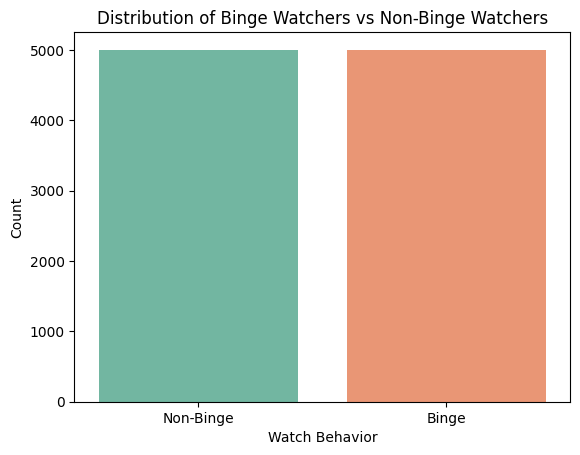

In [10]:
# Distribution of binge_watched
sns.countplot(data=df, x='binge_watched', palette='Set2')
plt.title("Distribution of Binge Watchers vs Non-Binge Watchers")
plt.xticks([0, 1], ['Non-Binge', 'Binge'])
plt.xlabel("Watch Behavior")
plt.ylabel("Count")
plt.show()


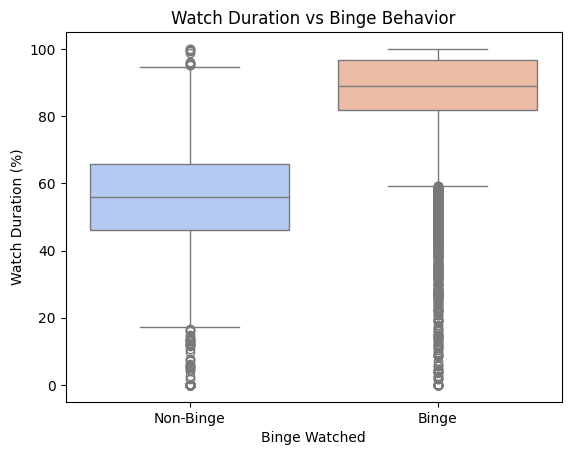

In [11]:
sns.boxplot(data=df, x='binge_watched', y='watch_duration_pct', palette='coolwarm')
plt.title("Watch Duration vs Binge Behavior")
plt.xticks([0, 1], ['Non-Binge', 'Binge'])
plt.xlabel("Binge Watched")
plt.ylabel("Watch Duration (%)")
plt.show()


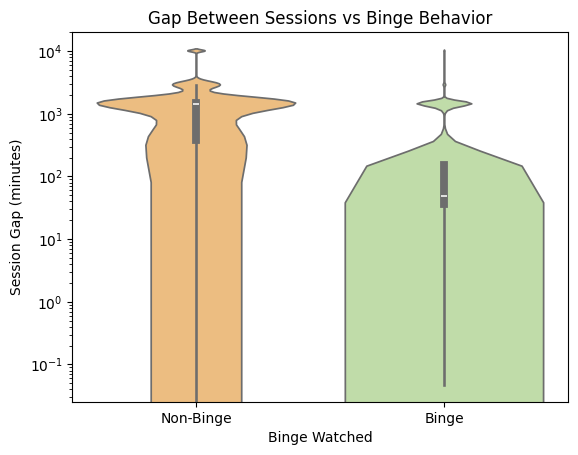

In [12]:
sns.violinplot(data=df, x='binge_watched', y='session_gap_minutes', palette='Spectral')
plt.title("Gap Between Sessions vs Binge Behavior")
plt.xticks([0, 1], ['Non-Binge', 'Binge'])
plt.xlabel("Binge Watched")
plt.ylabel("Session Gap (minutes)")
plt.yscale('log')  # If highly skewed
plt.show()


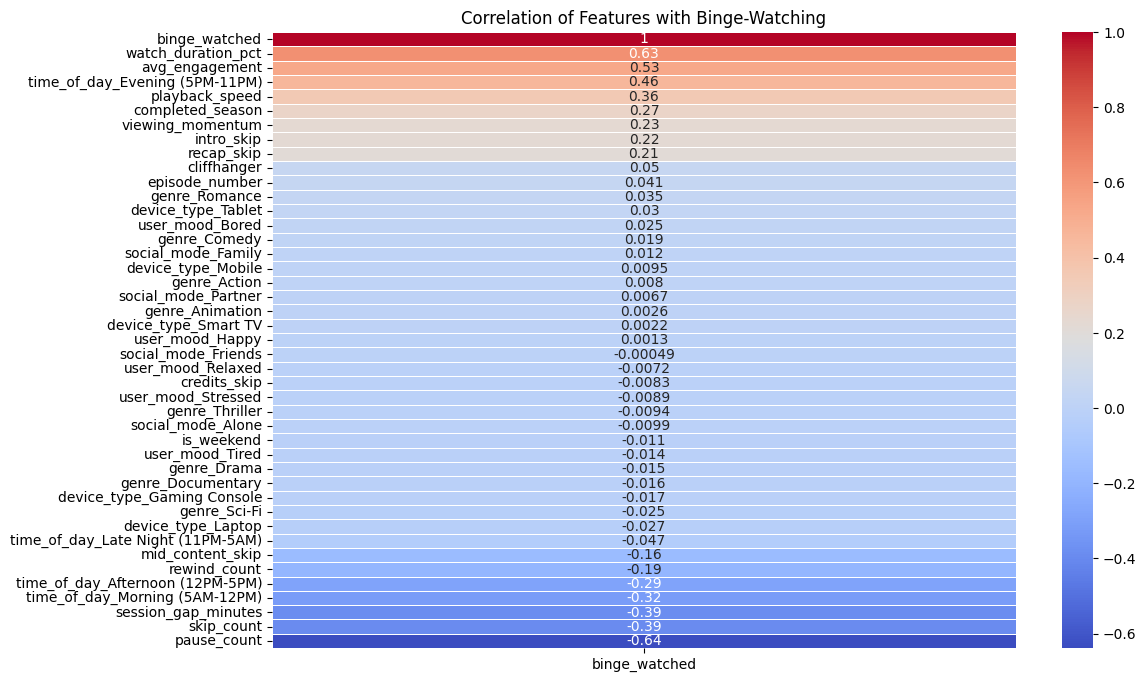

In [13]:
# Reconstruct full feature frame if needed
df_encoded = df.copy()
cat_cols = df_encoded.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df_encoded, columns=cat_cols)

# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix[['binge_watched']].sort_values(by='binge_watched', ascending=False),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation of Features with Binge-Watching")
plt.show()


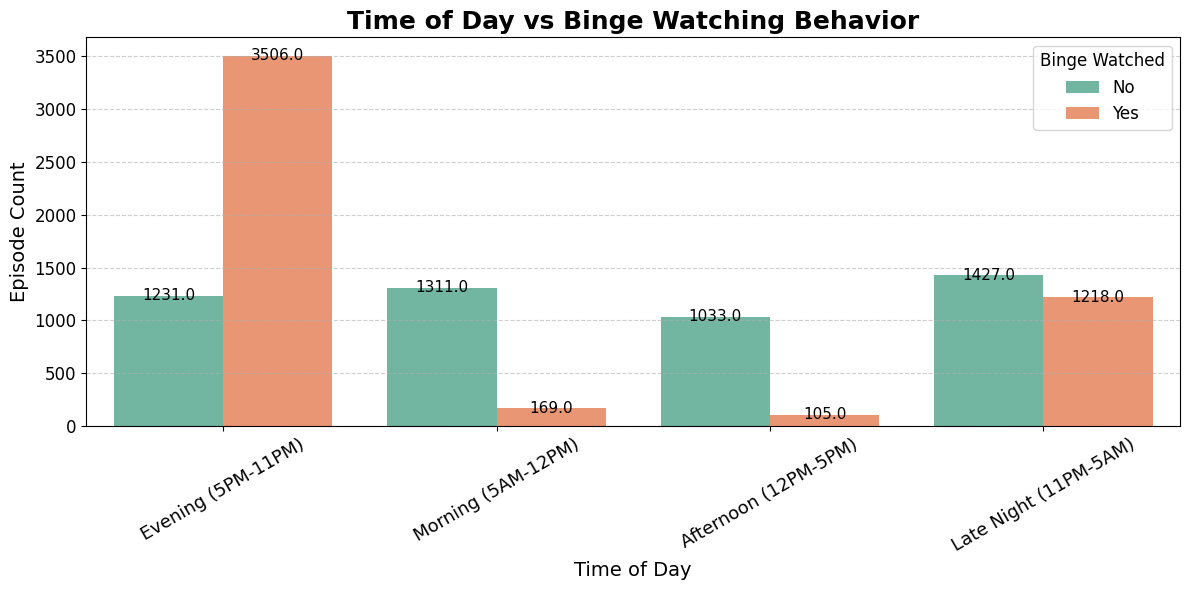

In [27]:
plt.figure(figsize=(12, 6))  # Wider plot
ax = sns.countplot(data=df, x='time_of_day', hue='binge_watched', palette='Set2')

# Title and axes
plt.title("Time of Day vs Binge Watching Behavior", fontsize=18, fontweight='bold')
plt.xlabel("Time of Day", fontsize=14)
plt.ylabel("Episode Count", fontsize=14)

# Rotate x-axis labels for clarity
plt.xticks(rotation=30, fontsize=13)
plt.yticks(fontsize=12)

# Grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with count
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f'{height}',
                    (bar.get_x() + bar.get_width() / 2., height + 2),
                    ha='center', va='center', fontsize=11, color='black')

# Improved legend
plt.legend(title='Binge Watched', labels=["No", "Yes"], title_fontsize=12, fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()


# **Model Evaluation**

In [25]:
cat_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=cat_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [52]:
# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),

    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN (k=3)": Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=3))
    ]),
    "Dummy Classifier": DummyClassifier(strategy="most_frequent")
}

In [53]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).set_index("Model").sort_values("F1-Score", ascending=False)
results_df

,Accuracy,Precision,Recall,F1-Score
Model,,,,
XGBoost,0.9565,0.987193,0.925,0.955085
Logistic Regression,0.9170,0.938947,0.892,0.914872
KNN (k=3),0.8865,0.877810,0.898,0.887790
Dummy Classifier,0.5000,0.000000,0.000,0.000000


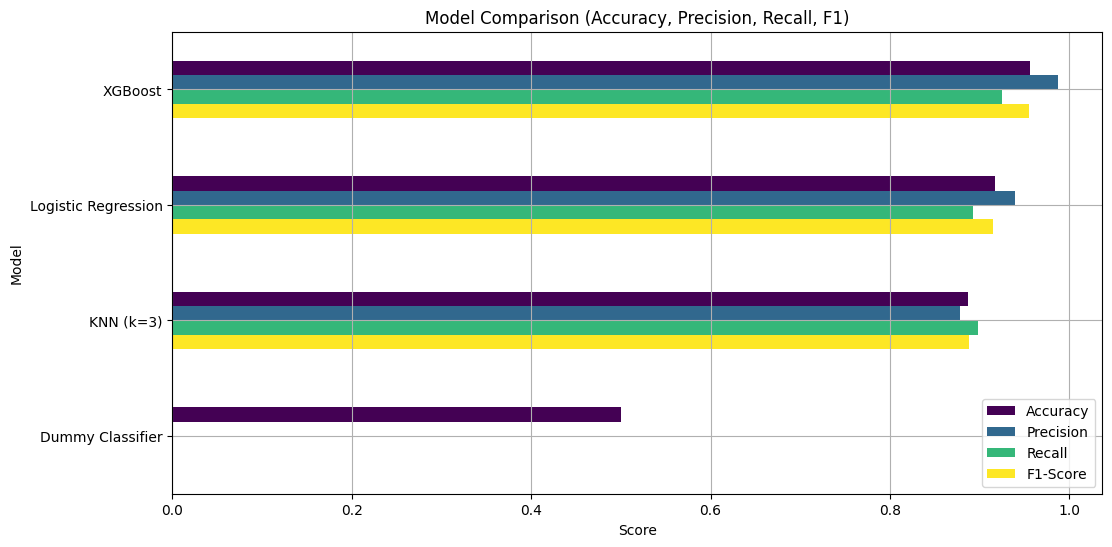

In [54]:

results_df.plot(kind='barh', figsize=(12, 6), colormap='viridis')
plt.title("Model Comparison (Accuracy, Precision, Recall, F1)")
plt.xlabel("Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


# **SHAP Explainability**

In [48]:
import shap
shap.initjs()

# Ensure the model is trained
xgb_model = models["XGBoost"]

# Create SHAP explainer for XGBoost
xgb_explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values
xgb_shap_values = xgb_explainer.shap_values(X_test)



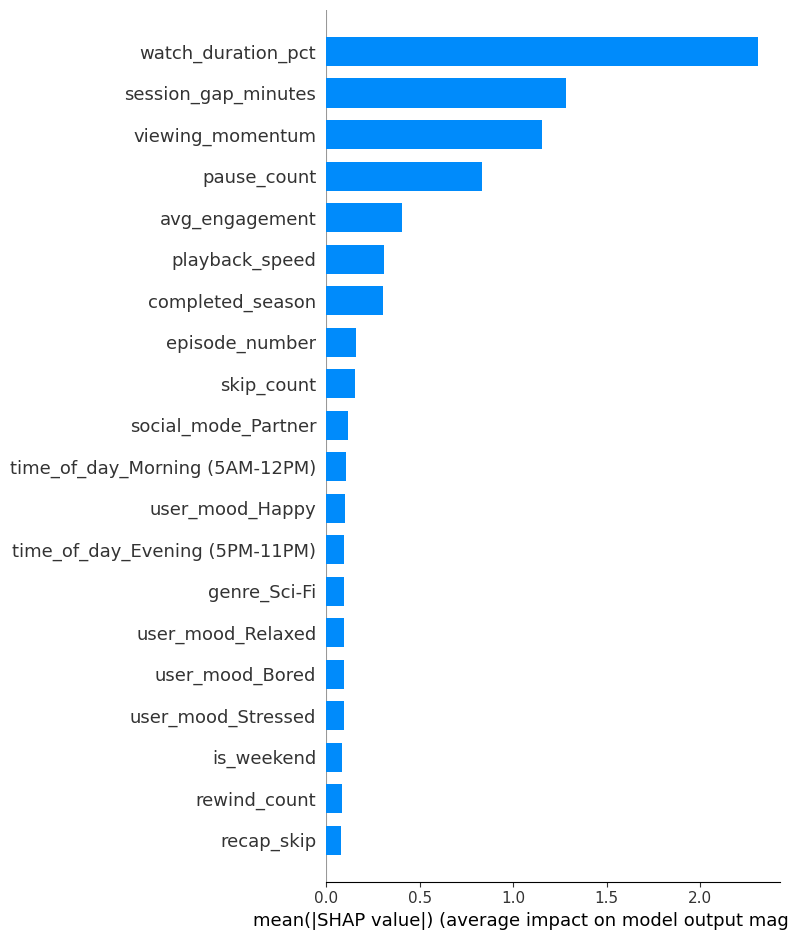

In [49]:
# SHAP Summary Plot (class 1 - binge watchers)
shap.summary_plot(xgb_shap_values, X_test, plot_type='bar')

In [55]:
print(results_df.to_latex(float_format='%.3f'))

\begin{tabular}{lrrrr}
\toprule
 & Accuracy & Precision & Recall & F1-Score \\
Model &  &  &  &  \\
\midrule
XGBoost & 0.957 & 0.987 & 0.925 & 0.955 \\
Logistic Regression & 0.917 & 0.939 & 0.892 & 0.915 \\
KNN (k=3) & 0.886 & 0.878 & 0.898 & 0.888 \\
Dummy Classifier & 0.500 & 0.000 & 0.000 & 0.000 \\
\bottomrule
\end{tabular}

